In [7]:
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K


def add_decorate(x):
    """
    axis = -1 --> last dimension in an array
    """
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)


def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

# model.add(Lambda(antirectifier, output_shape=antirectifier_output_shape))


lr = 2e-4  # 0.0002
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)


def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=None, input_shape=(ni_D,))) 
        # np.shape(100) == np.shape(100,)과 같은것. 그냥 문법적인 인정을 하고 넘어가자
        # y = np.zeros((2, 3, 4)) 과 y.shape = (24,) 를 프린트해보자.
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D

        G = models.Sequential()  # (Batch, ni_D)
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))  # (Batch, steps=ni_D, input_dim=1)
        G.add(Conv1D(nh_G, 1, activation='relu'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(1, 1))  # (Batch, ni_D, 1)
        G.add(Flatten())  # (Batch, ni_D)

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)


class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)


class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real data
        Real = data.real_sample(n_batch)  # (n_batch, ni_D)
        # print(Real.shape)
        # Generated data
        Z = data.in_sample(n_batch)  # (n_batch, ni_D)
        Gen = gan.G.predict(Z)  # (n_batch, ni_D)
        # print(Gen.shape)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        """
        generate a new image
        """
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        """
        train GAN and show the results
        for showing, the original and the artificial results will be compared
        """
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))


# class GAN_Pure(GAN):
#     def __init__(self, ni_D, nh_D, nh_G):
#         '''
#         Discriminator input is not added
#         '''
#         super().__init__(ni_D, nh_D, nh_G)

#     def gen_D(self):
#         ni_D = self.ni_D
#         nh_D = self.nh_D
#         D = models.Sequential()
#         # D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
#         D.add(Dense(nh_D, activation='relu', input_shape=(ni_D,)))
#         D.add(Dense(nh_D, activation='relu'))
#         D.add(Dense(1, activation='sigmoid'))

#         model_compile(D)
#         return D


# class Machine_Pure(Machine):
#     def __init__(self, n_batch=10, ni_D=100):
#         data_mean = 4
#         data_stddev = 1.25

#         self.data = Data(data_mean, data_stddev, ni_D)
#         self.gan = GAN_Pure(ni_D=ni_D, nh_D=50, nh_G=50)

#         self.n_batch = n_batch
#         # self.ni_D = ni_D


def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=2, n_show=200, n_test=100)

Stage 0 (Epoch: 0)
Mean and Std of Real: (3.9964561279344593, 1.2453499005846604)
Mean and Std of Gen: (2.4481711, 1.0697749)


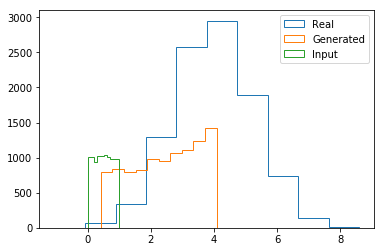

Stage 1 (Epoch: 200)
Mean and Std of Real: (4.015457228513548, 1.255249230022976)
Mean and Std of Gen: (3.5047126, 1.2821908)


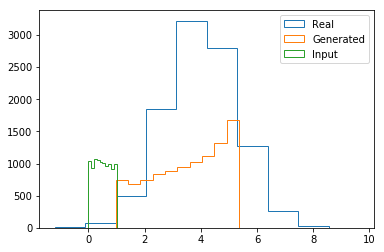

In [8]:
main()

In [4]:
real_sample = lambda n_batch: np.random.normal(4, 1.25, (n_batch, 100))

In [5]:
real_sample(1)

array([[3.03176604, 4.38481172, 3.89092615, 2.38223501, 4.84147091,
        5.54978007, 0.69236158, 3.72297457, 4.83506179, 6.3812466 ,
        4.99425978, 4.21388802, 3.75130963, 4.88945395, 3.43776848,
        3.70038717, 2.98278286, 4.61924152, 3.73936661, 4.50842032,
        4.26222458, 6.01363192, 3.79830779, 5.06986036, 3.29429154,
        4.78842465, 5.91559671, 3.34232823, 3.0317103 , 2.21423516,
        2.58322523, 4.31357318, 4.26452176, 4.16518086, 4.73195176,
        3.61605351, 3.14664103, 6.35642164, 5.73860371, 4.21398384,
        1.2282522 , 3.64658645, 2.72719993, 5.29714702, 3.16408339,
        3.26758316, 4.59721416, 1.99388293, 5.18377593, 4.22602484,
        4.01549768, 5.42989781, 3.5983266 , 3.5213028 , 1.85560193,
        5.81121125, 6.47729239, 2.84211022, 3.7788841 , 2.28966035,
        6.14659495, 2.9581311 , 3.87290564, 4.34832173, 6.09085647,
        1.42356613, 4.1874819 , 4.12886261, 4.19609768, 2.25220495,
        5.7930263 , 4.49100526, 4.52309225, 6.09

In [31]:
import os
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import optimizers


def add_decorate(x):
    """
    axis = -1 --> last dimension in an array
    """
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)


learning_rate = 0.001

model = Sequential()
model.add(Lambda(add_decorate, output_shape=None, input_shape=(100,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

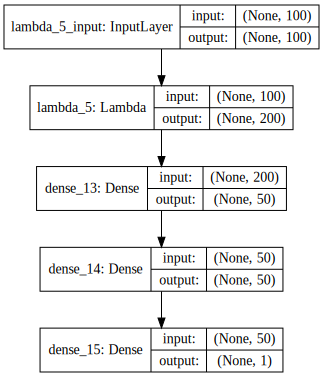

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
G = Sequential()
G = models.Sequential()  # (Batch, ni_D)
G.add(Reshape((100, 1), input_shape=(100,)))  # (Batch, steps=ni_D, input_dim=1)
G.add(Conv1D(50, 1, activation='relu'))  # (Batch, ni_D, nh_G)
G.add(Conv1D(50, 1, activation='sigmoid'))  # (Batch, ni_D, nh_G)
G.add(Conv1D(1, 1))  # (Batch, ni_D, 1)
G.add(Flatten())  # (Batch, ni_D)
optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)
G.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

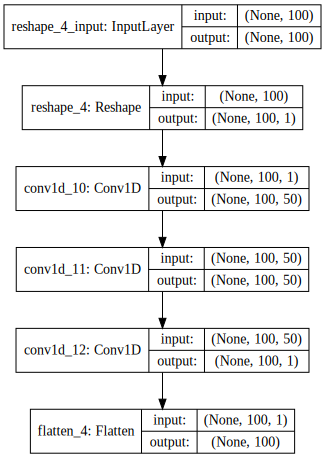

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(G, show_shapes=True).create(prog='dot', format='svg'))

## keras Backend K 함수의 사용법

In [42]:
b = K.random_uniform_variable(shape=(3, 4), low=0, high=1) # Uniform distribution
c = K.random_normal_variable(shape=(3, 4), mean=0, scale=1) # Gaussian distribution

# Tensor Arithmetic
a = K.concatenate([b, c], axis=-1)

In [43]:
b

<tf.Variable 'Variable_6:0' shape=(3, 4) dtype=float32_ref>

In [44]:
c

<tf.Variable 'Variable_7:0' shape=(3, 4) dtype=float32_ref>

In [45]:
a

<tf.Tensor 'concat_2:0' shape=(3, 8) dtype=float32>

#### np shape과의 비교를 통한 이해

In [35]:
y = np.zeros((3,4))
print(y)
print(y.shape)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [60]:
y = np.zeros((3,4))
x = np.zeros((3,3))
# y = np.zeros((3,4,2)) --> 이것도 됨
# x = np.zeros((3,4,5))

In [61]:
z = np.concatenate((y, x), axis=-1)

In [50]:
print(z)
print(z.shape)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
(3, 7)


In [63]:
y = np.zeros((4,3))
x = np.zeros((3,3))
# axis 0의 의미는 shape의 index의 의미. iterate하는 index 빼고는 모두 동일해야 함.
# y = np.zeros((4,3,1)) --> 됨
# x = np.zeros((3,3,1))
# y = np.zeros((4,3,1)) --> 안됨
# x = np.zeros((3,3,0))
z2 = np.concatenate((y, x), axis=0) 
print(z2)
print(z2.shape)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
(7, 3)
